In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = 'custom_feature_importance_results'
Path(SAVE_DIR).mkdir(exist_ok=True)

# %%
# Réseau plus petit pour CIFAR-10
class SmallCIFARNet(nn.Module):
    def __init__(self):
        super(SmallCIFARNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCIFARNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [4]:
# Compute accuracy
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [5]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

cifar10 = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=32, shuffle=True)

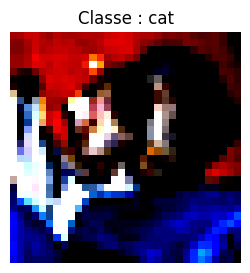

In [6]:
# Image test et affichage
test_img, test_label = cifar10_test[0]
test_img = test_img.unsqueeze(0).to(device)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(3,3))
img = test_img.squeeze().cpu().numpy().transpose((1,2,0))
plt.imshow(np.clip(img, 0, 1))
plt.title(f"Classe : {classes[test_label]}")
plt.axis('off')
plt.show()


In [7]:
def compute_feature_importance(model, input_tensor, layer_idx, feature_indices, pred_class):
    with torch.no_grad():
        output_original = model(input_tensor)
        original_score = torch.nn.functional.softmax(output_original, dim=1)[0, pred_class].item()

    def zero_out_features(module, input, output):
        for idx in feature_indices:
            if idx < output.shape[1]:  # Vérifie la validité de l'index
                output[:, idx, :, :] = 0
        return output

    hook = model.features[layer_idx].register_forward_hook(zero_out_features)

    with torch.no_grad():
        output_disabled = model(input_tensor)
        new_score = torch.nn.functional.softmax(output_disabled, dim=1)[0, pred_class].item()

    hook.remove()
    return original_score - new_score

In [8]:
# Training and Analysis
# Training parameters
n_epochs = 10
train_accuracies = []
test_accuracies = []
importances_history = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    
    # Training phase
    model.train()
    for inputs, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Compute accuracies
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    # Feature importance analysis
    model.eval()
    with torch.no_grad():
        output = model(test_img)
        test_label = torch.argmax(output, dim=1).item()
    
    importances = []
    for feature_idx in range(256):
        importance = compute_feature_importance(model, test_img, 4, [feature_idx], test_label)
        importances.append(importance)
    
    importances_history.append(importances)


Epoch 1/10


Training epoch 1: 100%|██████████| 1563/1563 [00:06<00:00, 247.39it/s]


Train Accuracy: 56.81%, Test Accuracy: 55.42%

Epoch 2/10


Training epoch 2: 100%|██████████| 1563/1563 [00:05<00:00, 284.52it/s]


Train Accuracy: 65.35%, Test Accuracy: 63.27%

Epoch 3/10


Training epoch 3: 100%|██████████| 1563/1563 [00:05<00:00, 284.85it/s]


Train Accuracy: 72.59%, Test Accuracy: 69.19%

Epoch 4/10


Training epoch 4: 100%|██████████| 1563/1563 [00:05<00:00, 287.21it/s]


Train Accuracy: 76.69%, Test Accuracy: 71.53%

Epoch 5/10


Training epoch 5: 100%|██████████| 1563/1563 [00:05<00:00, 272.90it/s]


Train Accuracy: 79.57%, Test Accuracy: 73.37%

Epoch 6/10


Training epoch 6: 100%|██████████| 1563/1563 [00:05<00:00, 274.17it/s]


Train Accuracy: 81.78%, Test Accuracy: 74.13%

Epoch 7/10


Training epoch 7: 100%|██████████| 1563/1563 [00:05<00:00, 269.78it/s]


Train Accuracy: 84.84%, Test Accuracy: 74.94%

Epoch 8/10


Training epoch 8: 100%|██████████| 1563/1563 [00:05<00:00, 272.52it/s]


Train Accuracy: 86.54%, Test Accuracy: 74.79%

Epoch 9/10


Training epoch 9: 100%|██████████| 1563/1563 [00:05<00:00, 277.63it/s]


Train Accuracy: 88.61%, Test Accuracy: 75.72%

Epoch 10/10


Training epoch 10: 100%|██████████| 1563/1563 [00:05<00:00, 269.08it/s]


Train Accuracy: 90.90%, Test Accuracy: 75.64%


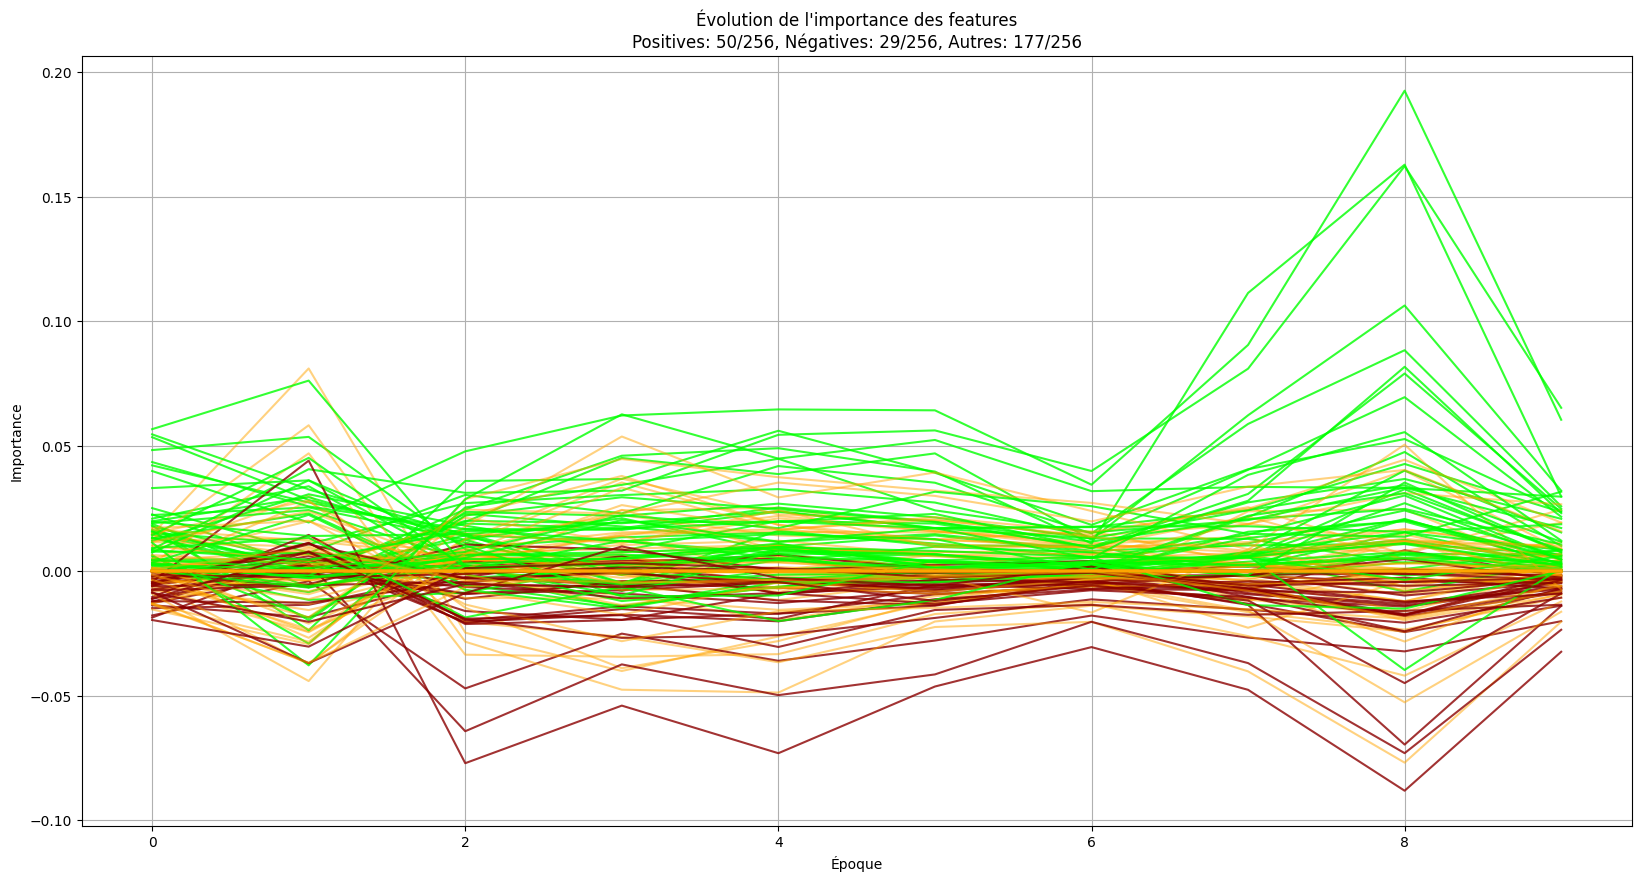

In [9]:
# Affichage avec mise en évidence et comptage des features
importances_array = np.array(importances_history)
plt.figure(figsize=(20, 10))

positive_count = 0
negative_count = 0
other_count = 0

total_features = importances_array.shape[1]

for feature_idx in range(total_features):
    importance_first_epoch = importances_array[0, feature_idx]
    importance_last_epoch = importances_array[-1, feature_idx]

    if importance_first_epoch > 0 and importance_last_epoch > 0:
        color = 'lime'  # Toujours positif (plus vif)
        alpha = 0.8
        positive_count += 1
    elif importance_first_epoch < 0 and importance_last_epoch < 0:
        color = 'darkred'  # Toujours négatif (plus vif)
        alpha = 0.8
        negative_count += 1
    else:
        color = 'orange'  # Changé de signe
        alpha = 0.5
        other_count += 1

    plt.plot(range(len(importances_history)), importances_array[:, feature_idx], color=color, alpha=alpha)

# Affiche les statistiques
plt.title(f"Évolution de l'importance des features\n"
          f"Positives: {positive_count}/{total_features}, "
          f"Négatives: {negative_count}/{total_features}, "
          f"Autres: {other_count}/{total_features}")
plt.xlabel("Époque")
plt.ylabel("Importance")
plt.grid(True)
plt.savefig(f'{SAVE_DIR}/custom_feature_evolution_highlighted.png')
plt.show()

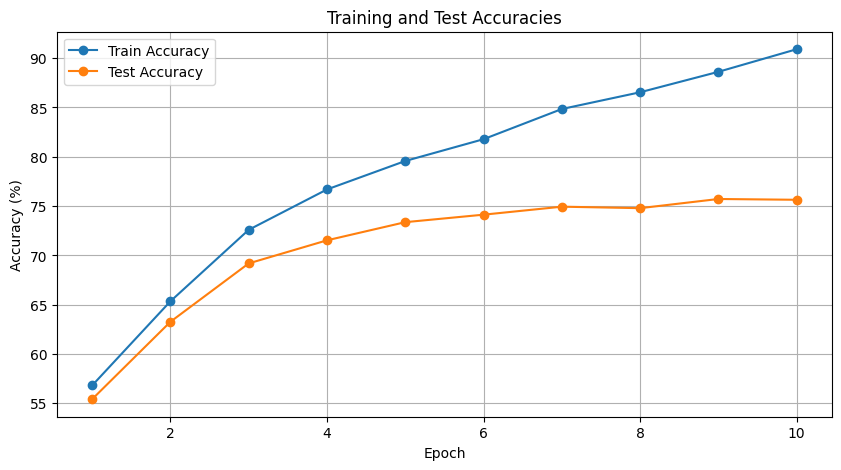


Final Accuracies:
Train Accuracy: 90.90%
Test Accuracy: 75.64%


In [10]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, n_epochs+1), test_accuracies, label='Test Accuracy', marker='o')
plt.title('Training and Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig(f'{SAVE_DIR}/accuracy_evolution.png')
plt.show()

# Print final accuracies
print("\nFinal Accuracies:")
print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Test Accuracy: {test_accuracies[-1]:.2f}%")